# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Loading the Dataset </div></b>

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset
from collections import defaultdict
from datasets import DatasetDict


langs = ["de", "fr", "it", "en"]
fracs= [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's take a look at the number of training examples of all datasets:

In [3]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["number of training examples"])

,de,fr,it,en
number of training examples,12580,4580,1680,1180


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Understanding the Dataset </div></b>

In [4]:
element = panx_ch["de"]["train"][0]

for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [5]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [6]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Preprocessing </div></b>

In [7]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [8]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] +=1

pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Bert Tokenizer vs XLM-R Tokenizer </div></b>

In [9]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [10]:
text = "Tim Sparrow lives San Diego!"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

pd.DataFrame([bert_tokens, xlmr_tokens], index = ["BERT","XLM-R"])

,0,1,2,3,4,5,6,7,8
BERT,[CLS],Tim,Spa,##rrow,lives,San,Diego,!,[SEP]
XLM-R,<s>,▁Tim,▁Spar,row,▁lives,▁San,▁Diego,!,</s>


In [11]:
from transformers import XLMRobertaForTokenClassification
import torch

xlmr_model_name = "xlm-roberta-base"
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
num_labels = tags.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    num_labels = num_labels,
    id2label=index2tag,
    label2id=tag2index
).to(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = "pt")

pd.DataFrame([xlmr_tokens, input_ids[0].numpy()],  index = ["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Tim,▁Spar,row,▁lives,▁San,▁Diego,!,</s>
Input IDs,0,13320,37456,15555,60742,1735,59826,38,2


In [13]:
outputs = xlmr_model(input_ids.to(device)).logits

predictions = torch.argmax(outputs, dim=-1)

preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

pd.DataFrame( [xlmr_tokens, preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Tim,▁Spar,row,▁lives,▁San,▁Diego,!,</s>
Tags,B-ORG,B-PER,B-ORG,B-PER,B-PER,B-ORG,B-PER,B-PER,B-ORG


In [14]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer.encode(
        text, return_tensors = "pt").to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Tokenizer for NER Analysis </div></b>

In [15]:
words, labels = de_example["tokens"], de_example["ner_tags"]

pd.DataFrame([words, labels], index = ["words", "labels"])

,0,1,2,3,4,5,6,7,8,9,10,11
words,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
labels,0,0,0,0,5,6,0,0,5,5,6,0


In [16]:
tokenized_input = xlmr_tokenizer(de_example["tokens"],is_split_into_words=True)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [17]:
word_ids = tokenized_input.word_ids()

pd.DataFrame([tokens, word_ids], index = ["Tokens","Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [18]:
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]

index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [19]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], 
                                     truncation = True,
                                     is_split_into_words = True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs        

In [20]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,
                     batched=True,
                     remove_columns=["langs", "ner_tags", "tokens"])

panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Metrics </div></b>

In [21]:
!pip install -q seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [23]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)  
        preds_list.append(example_preds) 
    
    return preds_list, labels_list

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Training </div></b>

In [24]:
from transformers import TrainingArguments

num_epochs= 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = "multilingual-xlm-roberta-for-ner"

training_args = TrainingArguments(
    output_dir = model_name,
    log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy = "epoch", 
    save_steps = 1e6,
    weight_decay = 0.01,
    logging_steps = logging_steps,
    report_to= "none",
    push_to_hub = True
)

In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(
                        eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [27]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [28]:
def model_init():
    return xlmr_model

In [30]:
from transformers import Trainer

trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = panx_de_encoded["train"],
    eval_dataset = panx_de_encoded["validation"],
    tokenizer = xlmr_tokenizer,
)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.162742,0.822943
2,0.214000,0.140953,0.847188
3,0.214000,0.134316,0.860762


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

'https://huggingface.co/Tirendaz/multilingual-xlm-roberta-for-ner/tree/main/'

In [31]:
text_de = "tim Dean ist ein Informatiker bei Google in Kalifornien"

tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁tim,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Cross-Lingual Transfer</div></b>

In [32]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [33]:
f1_scores = defaultdict(dict)

In [36]:
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.864


In [37]:
text_fr = "Tim Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags , trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Tim,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [38]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [39]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


F1-score of [de] model on [fr] dataset: 0.704


In [40]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.692


In [41]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.588


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Zero-Shot Model vs Fine-Tuned Model</div></b>

In [42]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    trainer = Trainer(
        model_init = model_init,
        args = training_args,
        data_collator = data_collator,
        compute_metrics = compute_metrics,
        train_dataset = train_ds,
        eval_dataset = valid_ds,
        tokenizer = xlmr_tokenizer,
    )
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub()
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
                {"num_samples": [len(train_ds)], "f1_score": [f1_score]})    

In [43]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

training_args.push_to_hub= False

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [44]:
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,No log,0.423920,0.757959
2,0.453800,0.347623,0.781598
3,0.453800,0.369679,0.780891


,num_samples,f1_score
0,250,0.787128


In [45]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df._append(train_on_subset(panx_fr_encoded, num_samples),
                                   ignore_index = True)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.392676,0.752472
2,0.267300,0.373878,0.778930
3,0.267300,0.351229,0.797454


Epoch,Training Loss,Validation Loss,F1
1,No log,0.313281,0.794744
2,0.203500,0.324456,0.815723
3,0.203500,0.322292,0.815236


Epoch,Training Loss,Validation Loss,F1
1,No log,0.290939,0.817618
2,0.173500,0.306709,0.826765
3,0.173500,0.324881,0.831706


Epoch,Training Loss,Validation Loss,F1
1,No log,0.286560,0.827633
2,0.176400,0.282978,0.840458
3,0.176400,0.290376,0.838873


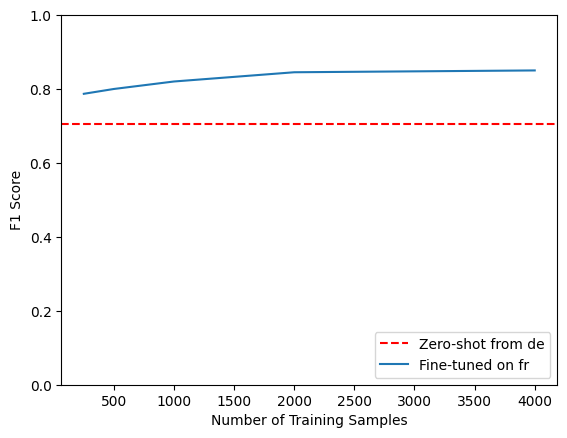

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axhline(f1_scores['de']['fr'], ls = "--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## Resource

- [NLP with Transformers](https://github.com/nlp-with-transformers/notebooks/blob/main/04_multilingual-ner.ipynb)

Thanks for reading. If you like this notebook, don't forget to upvote ☺️

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [X](http://x.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) 😎